In [2]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from sklearn.exceptions import InconsistentVersionWarning
import warnings
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
# Suppress UserWarning: X does not have valid feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")


Training samples: 1132523, Test samples: 283131

Dataset loaded successfully!



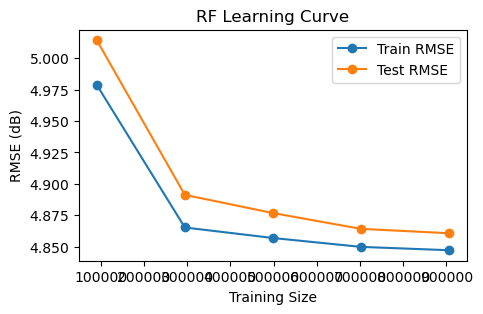

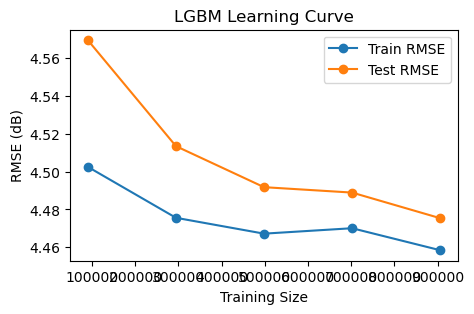

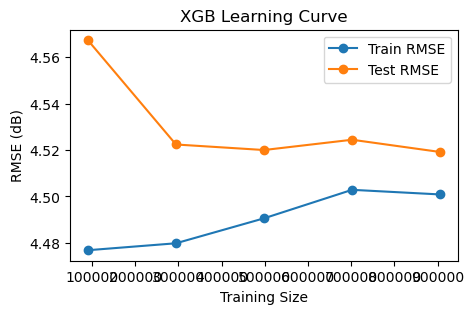

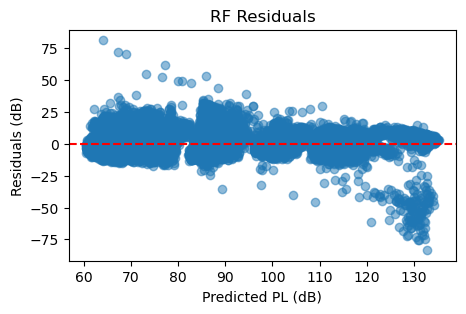

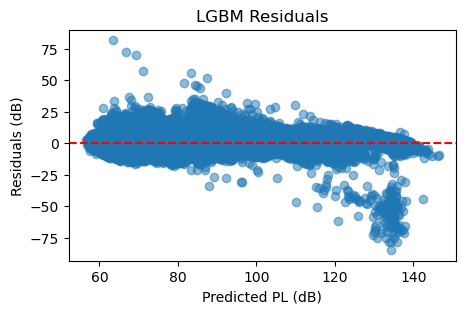

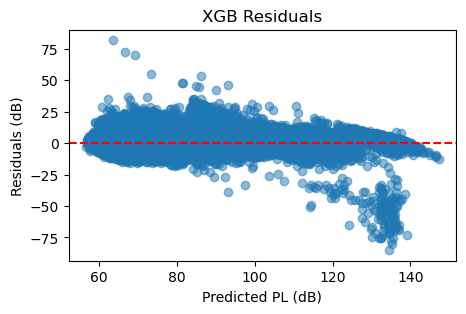

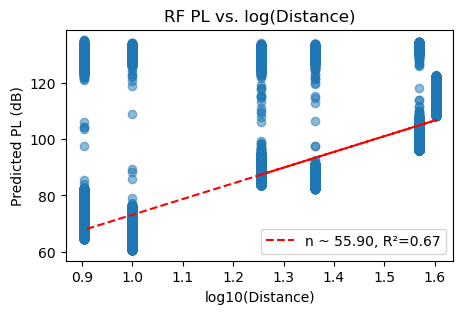

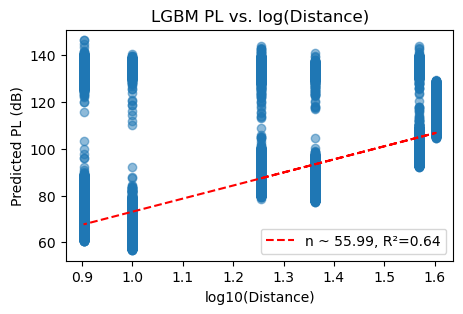

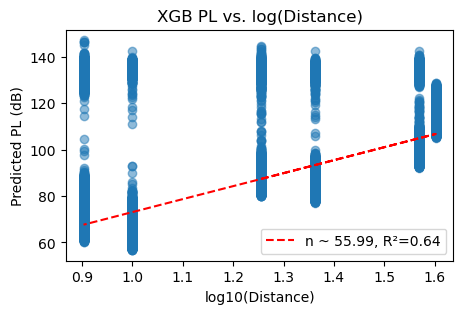

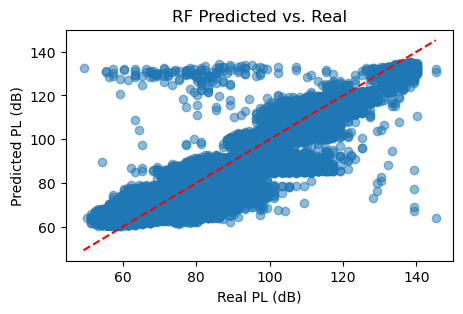

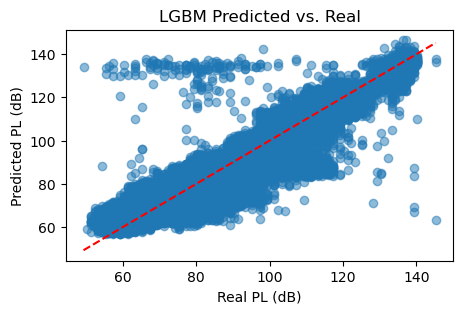

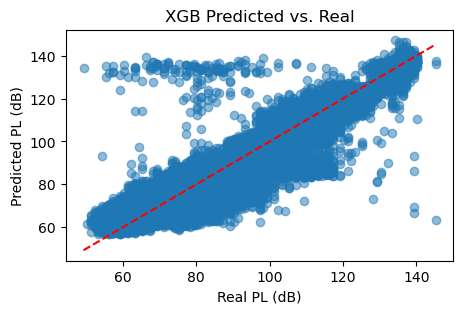

In [3]:
# Path to the standardized database directory
base_path = '../Comprehensive ML - Files & Plots etc.'

df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print('\nDataset loaded successfully!\n')

# Load models from Models folder
with open('Models/rf_final_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
with open('Models/lgbm_final_model.pkl', 'rb') as f:
    lgb_model = pickle.load(f)
with open('Models/xgb_final_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

models = {'RF': rf_model, 'LGBM': lgb_model, 'XGB': xgb_model}
figsize = (5, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curves (RMSE vs. data size)
for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_root_mean_squared_error')
    train_rmse = -train_scores.mean(1)
    test_rmse = -test_scores.mean(1)
    plt.figure(figsize=figsize)
    plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
    plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
    plt.xlabel('Training Size')
    plt.ylabel('RMSE (dB)')
    plt.title(f'{name} Learning Curve')
    plt.legend()
    #plt.savefig(f'{path}{name}_learning_curve.png', dpi=300)
    plt.show()

# 2. Residual Analysis (predicted vs. residuals, check patterns)
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    residuals = y_test - y_test_pred
    plt.figure(figsize=figsize)
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted PL (dB)')
    plt.ylabel('Residuals (dB)')
    plt.title(f'{name} Residuals')
    #plt.savefig(f'{path}{name}_residuals.png', dpi=300)
    plt.show()

# 3. Physics Consistency (predicted PL vs. log(distance), fit n)
dist = df_test['distance'].values  # Assume distance column
log_dist = np.log10(dist + 1e-6)  # Avoid log(0)
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
    plt.figure(figsize=figsize)
    plt.scatter(log_dist, y_test_pred, alpha=0.5)
    plt.plot(log_dist, intercept + slope * log_dist, 'r--', label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
    plt.xlabel('log10(Distance)')
    plt.ylabel('Predicted PL (dB)')
    plt.title(f'{name} PL vs. log(Distance)')
    plt.legend()
    #plt.savefig(f'{path}{name}_physics_consistency.png', dpi=300)
    plt.show()

# 4. Predicted vs. Real PL (scatter with identity line)
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    plt.figure(figsize=figsize)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Real PL (dB)')
    plt.ylabel('Predicted PL (dB)')
    plt.title(f'{name} Predicted vs. Real')
    #plt.savefig(f'{path}{name}_pred_vs_real.png', dpi=300)
    plt.show()